# Model

W procesie modelowania tworzymy dwa modele, bazowy i docelowy.

Przed trenowaniem modeli wczytujemy atrybuty wybrane na etapie analizy danych:
- miasto
- firma kurierska
- dzień tygodnia zakupu
- pora dnia zakupu

Dodatkowo wczytujemy inne atrybuty, by sprawdzić przewidywany na etapie analizy danych ich niewielki wpływ na dokładność modelu:
- kategoria produktu
- cena produktu

Nie rozważamy innych danych, takich jak dokładne dane odbiorcy czy nazwa produktu, nawet jako atrybutów dodatkowych w celu sprawdzenia wniosków z analizy danych, gdyż ich wykorzystanie w praktyce uniemożliwiłoby eksploatację modelu w sklepie, w którym nowi klienci i produkty stale się pojawiają.

Na etapie wczytywania dane poddajemy również normalizacji oraz w niektórych przypadkach dodatkowym przekształceniom. Dla każdego atrybutu opisujemy te działania w odpowiedniej sekcji.

## Wczytanie danych

Zaczynamy od wczytania wszystkich danych z plików.

In [1]:
#installs pandasql within jupyter kernel
%pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import json
from datetime import datetime
import time
import pandas as pd
from pandasql import sqldf
import csv

In [3]:
dataPath = "IUM21L_Zad_03_02_v2"
citiesPath = "cities.csv"

In [4]:
deliveriesFile = open(dataPath + "/deliveries.jsonl", "r")
productsFile = open(dataPath + "/products.jsonl", "r")
sessionsFile = open(dataPath + "/sessions.jsonl", "r")
usersFile = open(dataPath + "/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

deliveriesDF = pd.DataFrame.from_dict(deliveries)
productsDF = pd.DataFrame.from_dict(products)
sessionsDF = pd.DataFrame.from_dict(sessions)
usersDF = pd.DataFrame.from_dict(users)

pysqldf = lambda q: sqldf(q, globals())
dataDF = pysqldf("SELECT * FROM sessionsDF s JOIN deliveriesDF d ON s.purchase_id = d.purchase_id JOIN productsDF p ON s.product_id = p.product_id JOIN usersDF u ON s.user_id = u.user_id;")
projectedDataDF = pysqldf("SELECT purchase_timestamp, delivery_timestamp, delivery_company, offered_discount, product_name, price, category_path, name, city, street FROM dataDF;")

In [5]:
pysqldf("SELECT * FROM projectedDataDF LIMIT 5;")

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street
0,2021-04-01T15:52:47,2021-04-02T14:06:34.432964,620,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,2021-04-01T02:26:23,2021-04-02T10:45:27.707128,360,15,Philips SDV5225,129.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
2,2021-01-03T05:11:17,2021-01-04T15:43:07.635371,620,0,Kinect Joy Ride (Xbox 360),69.00,Gry i konsole;Gry na konsole;Gry Xbox 360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
3,2021-02-17T12:59:54,2021-02-18T11:52:42.608746,620,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
4,2021-02-13T09:17:52,2021-02-15T08:59:28.973167,620,5,Doom 3 (PC),19.99,Gry i konsole;Gry komputerowe,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53


## Przygotowanie danych

W tej sekcji wczytujemy i przygotowujemy dane odpowiadające każdemu z atrybutów.

### Funkcje i struktury pomocnicze

Przed kolejnym krokiem wyznaczamy z otrzymanych danych wartości najbardziej dla nas przydatne, między innymi:
- czas trwania procesu dostarczania przesyłki na podstawie casu zakupu i dostawy
- dzień tygodnia zakupu na podstawie daty zakupu, przedstawiony jako liczba całkowita od 0 do 6, gdzie 0 oznacza poniedziałek, a 6 niedzielę

In [6]:
# Convert date to unix timestamp (seconds only)
def dateToTimestamp(date):
    date = date.split('.')[0]
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()
    return time.mktime(date)

def timestampToDate(timestamp):
    return datetime.fromtimestamp(timestamp).strftime("%Y-%m-%dT%H:%M:%S")


# Creates one-hot encoding based on data in extendedDataDF
def readDiscreteAttribute(name):
    names = pysqldf("SELECT " + name + " FROM extendedDataDF;").to_numpy()
    distinctNames = np.unique(names)
    distinctNames.sort()
    attribute = np.zeros(shape=(len(names), len(distinctNames)))
    for i in range(len(names)):
        attribute[i, np.where(names[i] == distinctNames)[0]] = 1
    return attribute


def attributeHist(attribute, bins, xlabel, ylabel = "Number of deliveries"):
    plt.hist(attribute, bins=bins, density=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


N_SECONDS = 3600.0

extendedDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE purchase_timestamp < delivery_timestamp")

#create columns
extendedDataDF["purchase_timestamp_sec"] = 0
extendedDataDF["delivery_timestamp_sec"] = 0
extendedDataDF["delivery_time_h"] = 0.0
extendedDataDF["purchase_day_name"] = ""

for index, _ in extendedDataDF.iterrows():
    extendedDataDF.at[index, "purchase_timestamp_sec"] = dateToTimestamp(extendedDataDF["purchase_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_timestamp_sec"] = dateToTimestamp(extendedDataDF["delivery_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_time_h"] = float(extendedDataDF["delivery_timestamp_sec"].iloc[index] - extendedDataDF["purchase_timestamp_sec"].iloc[index]) / N_SECONDS
    extendedDataDF.at[index, "purchase_timestamp"] = pd.to_datetime(extendedDataDF["purchase_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_timestamp"] = pd.to_datetime(extendedDataDF["delivery_timestamp"].iloc[index])
    extendedDataDF.at[index, "purchase_day_name"] = extendedDataDF["purchase_timestamp"].iloc[index].day_name()
    extendedDataDF.at[index, "purchase_day_index"] = (int(extendedDataDF["purchase_timestamp"].iloc[index].strftime("%w")) + 6) % 7
    extendedDataDF.at[index, "delivery_company_id"] = int(extendedDataDF["delivery_company"].iloc[index])

extendedDataDF

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street,purchase_timestamp_sec,delivery_timestamp_sec,delivery_time_h,purchase_day_name,purchase_day_index,delivery_company_id
0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1617285167,1617365194,22.229722,Thursday,3.0,620.0
1,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,15,Philips SDV5225,129.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1617236783,1617353127,32.317778,Thursday,3.0,360.0
2,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,0,Kinect Joy Ride (Xbox 360),69.00,Gry i konsole;Gry na konsole;Gry Xbox 360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1609647077,1609771387,34.530556,Sunday,6.0,620.0
3,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1613563194,1613645562,22.880000,Wednesday,2.0,620.0
4,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,5,Doom 3 (PC),19.99,Gry i konsole;Gry komputerowe,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1613204272,1613375968,47.693333,Saturday,5.0,620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,2021-04-15 13:00:45,2021-04-16 08:00:40.223545,516,5,Manta DVD064,109.00,Sprzęt RTV;Video;Odtwarzacze DVD,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1618484445,1618552840,18.998611,Thursday,3.0,516.0
7283,2021-01-28 09:32:38,2021-01-29 14:26:03.596544,360,20,Kyocera FS-3540MFP,5126.00,Komputery;Drukarki i skanery;Biurowe urządzeni...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1611822758,1611926763,28.890278,Thursday,3.0,360.0
7284,2021-03-22 20:30:58,2021-03-24 08:26:34.660190,620,10,Szalone Króliki Na żywo i w kolorze (Xbox 360),49.99,Gry i konsole;Gry na konsole;Gry Xbox 360,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1616441458,1616570794,35.926667,Monday,0.0,620.0
7285,2021-02-19 03:55:11,2021-02-20 18:26:44.646625,620,15,HTC HS-S200,14.99,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1613703311,1613842004,38.525833,Friday,4.0,620.0


### Miasta

Miasto odbiorcy przesyłki jest specyficznym atrybutem. W danych występuje kilka miast, których podane są nazwy. Gdybyśmy jednak traktowali miasta jak atrybut dyskretny nominalny, nie bylibyśmy w stanie przewidywać czasu dostawy do miast nieobecnych w danych, co z pewnością bardzo ograniczyłoby wykorzystanie modelu w sklepie. Wykorzystujemy więc zewnętrzną bazę danych zawierającą nazwy miast w Polsce i ich współrzędne geograficzne, które wykorzystamy w modelu.

Baza zawiera kilka miast spoza Polski, stąd nie przetwarzamy miast z bazy, których współrzędne wykraczają poza któryś ze zdefiniowanych zakresów współrzędnych. Wartości minimalne i maksymalne współrzędnych zdefiniowane są na początku kolejnej komórki i są one równe współrzędnym punktów krańcowych Polski.

Po wczytaniu współrzędnych każdego miasta, skalujemy je do przedziału [0; 1] wykorzystując wspomniane już wartości minimalne i maksymalne współrzędnych Polski wyrażonych w stopniach. Wykorzystanie tych powszechnie znanych wartości pozwala na wykonanie takiej samej normalizacji bez posiadania tej samej bazy współrzędnych miast (w przeciwieństwie do wykorzystania skrajnych wartości współrzędnych obecnych w innej bazie lub w dostarczonych danych). 

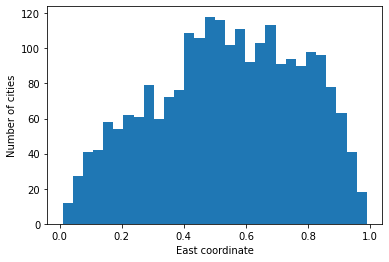

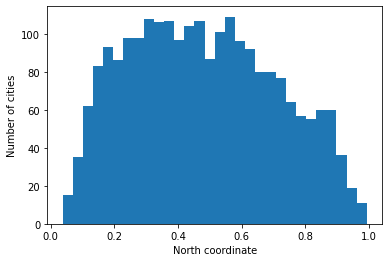

In [7]:
# Convert cities to coordinates, and then normalize the coordinates based on min and max values for Poland

# Read cities coordinates from csv file
# Strip cities names of whitespaces and convert coordinates to floats [degrees] by dividing minutes by 60
# City data contains few cities outside Poland, so we skip them using the following bounds
minEastCoord = 14.11
maxEastCoord = 24.15
minNorthCoord = 49
maxNorthCoord = 54.84

cityDatabaseNames = []
cityDatabaseCoords = []
with open(citiesPath, newline='') as csvfile:
    citiesReader = csv.reader(csvfile)
    for row in citiesReader:
        coordRow = []
        for cell in row:
            cell = cell.strip()
            if len(cell) > 1:
                if cell[-1] == 'E' or cell[-1] == 'N':
                    numericCoord = float(cell[0:2]) + float(cell[3:5])/60
                    coordRow.append(numericCoord)
                else:
                    cityDatabaseNames.append(cell)
        if coordRow[0] >= minEastCoord and \
           coordRow[0] <= maxEastCoord and \
           coordRow[1] >= minNorthCoord and \
           coordRow[1] <= maxNorthCoord:
            cityDatabaseCoords.append(coordRow)
        else:
            del cityDatabaseNames[-1]
            
        
#Convert to numpy
citiesCoordinatesDataArray = np.array(cityDatabaseCoords)

citiesCoordinatesDataArray[:, 0] = (citiesCoordinatesDataArray[:, 0]-minEastCoord)/(maxEastCoord-minEastCoord)
citiesCoordinatesDataArray[:, 1] = (citiesCoordinatesDataArray[:, 1]-minNorthCoord)/(maxNorthCoord-minNorthCoord)
   
attributeHist(citiesCoordinatesDataArray[:,0], bins=30, xlabel="East coordinate", ylabel="Number of cities")
attributeHist(citiesCoordinatesDataArray[:,1], bins=30, xlabel="North coordinate", ylabel="Number of cities")

Stworzone struktury danych wykorzystujemy do przekształcenia nazw miast z danych sklepu do znormalizowanych współrzędnych geograficznych.

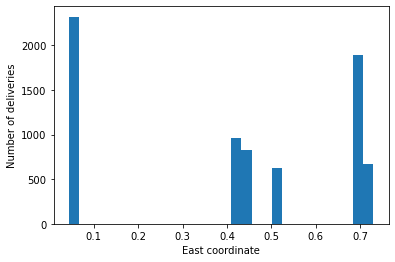

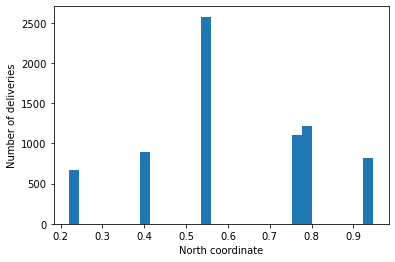

(7287, 2)


In [8]:
# Get city attribute
citiesNames = pysqldf("SELECT City FROM projectedDataDF;").to_numpy()

cityCoordAttribute = np.empty(shape=(citiesNames.size, 2))
for i in range(len(citiesNames)):
    index = cityDatabaseNames.index(citiesNames[i])
    cityCoordAttribute[i] = citiesCoordinatesDataArray[index]
    
attributeHist(cityCoordAttribute[:,0], bins=30, xlabel="East coordinate")
attributeHist(cityCoordAttribute[:,1], bins=30, xlabel="North coordinate")
print(cityCoordAttribute.shape)

### Firma kurierska

Kolejnym wczytywanym atrybutem jest firma kurierska. Jest to mało liczny atrybut dyskretny nominalny, stąd stosujemy kodowanie wskaźnikowe.

In [9]:
companyAttribute = readDiscreteAttribute("delivery_company_id")
print(companyAttribute)
print(companyAttribute.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
(7287, 3)


### Dzień tygodnia zakupu

Jest to również atrybut dyskretny nominalny i stosujemy kodowanie wskaźnikowe.

In [10]:
dayAttribute = readDiscreteAttribute("purchase_day_index")
print(dayAttribute)
print(dayAttribute.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(7287, 7)


### Pora dnia zakupu

Z posiadanej daty i godziny zakupu wyznaczamy liczbę sekund, jaka minęła od początku doby, w której nastąpił zakup. Następnie skalujemy tę liczbę do przedziału [0; 1].

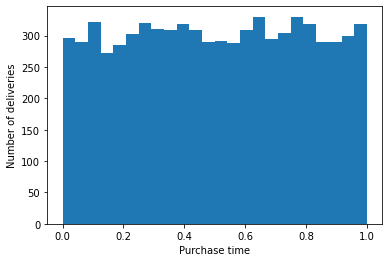

(7287, 1)


In [11]:
purchaseTimes = pysqldf("SELECT purchase_timestamp FROM extendedDataDF;").to_numpy()

datetimes = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f') for t in purchaseTimes[:,0]]
purchaseTimeAttribute = np.asarray([t.hour*3600 + t.minute*60 + t.second for t in datetimes], dtype=np.float32)
purchaseTimeAttribute /= 3600*24

attributeHist(purchaseTimeAttribute, bins=24, xlabel="Purchase time")
purchaseTimeAttribute = np.reshape(purchaseTimeAttribute, (-1, 1))
print(purchaseTimeAttribute.shape)

### Czas dostawy

Zmienną celu wczytujemy bezpośrednio jako czas trwania procesu dostawy wyrażonego w godzinach jako liczba zmiennoprzecinkowa.

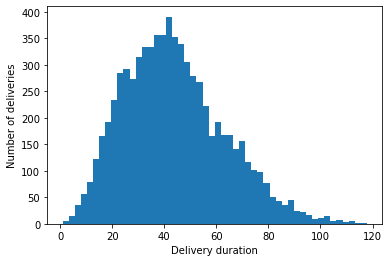

(7287, 1)


In [12]:
deliveryTimes = pysqldf("SELECT delivery_time_h FROM extendedDataDF;").to_numpy()
attributeHist(deliveryTimes, bins=50, xlabel="Delivery duration")
print(deliveryTimes.shape)

## Atrybuty dodatkowe

Wczytujemy również niektóre atrybuty, których nie wybraliśmy na etapie analizy danych, by sprawdzić jak ich wykorzystanie wpłynie na dokładność trenowanych modeli.

### Kategoria produktu

Stosujemy kodowanie wskaźnikowe.

In [13]:
categoryAttribute = readDiscreteAttribute("category_path")
print(categoryAttribute)
print(categoryAttribute.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(7287, 15)


### Cena

Sprawdzimy rónież wpływ wykorzystania ceny jako atrybutu na dokładność modelu. Jako że zdecydowanie więcej jest tańszych produktów w ramach normalizacji wyliczamy również logarytm z ceny i skalujemy go do przedziału [0; 1].

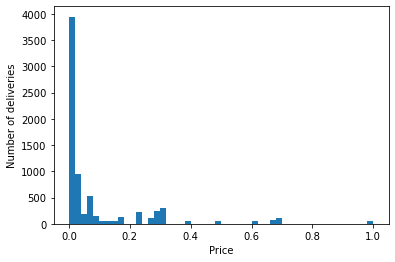

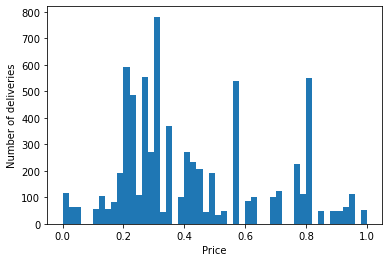

(7287, 1)
(7287, 1)


In [14]:
priceAttribute = pysqldf("SELECT price FROM extendedDataDF;").to_numpy()
priceAttributeLog = np.log(priceAttribute)

priceAttribute = (priceAttribute - np.min(priceAttribute)) / (np.max(priceAttribute) - np.min(priceAttribute))
priceAttributeLog = (priceAttributeLog - np.min(priceAttributeLog)) / (np.max(priceAttributeLog) - np.min(priceAttributeLog))

attributeHist(priceAttribute, bins=50, xlabel="Price")
attributeHist(priceAttributeLog, bins=50, xlabel="Price")
print(priceAttribute.shape)
print(priceAttributeLog.shape)

## Podział na zbiory treningowy i testowy

Z wczytanych danych tworzymy jedną strukturę danych, w której wiersze stanowią pojedynczą próbkę zawierającą wartości atrybutów i funkcji celu. Wiersze te w funkcji createDatasets mieszamy losowo ze znanym ziarnem i dzielimy na zbiory treningowy i testowy w stosunku 4:1.

In [15]:
def createDatasets(data, seed, trainingPart=0.8):
    np.random.seed(seed)
    np.random.shuffle(data)
    trainSize = int(trainingPart*len(data))
    trainData, testData = data[:trainSize,:-1], data[trainSize:,:-1]
    trainLabels, testLabels = data[:trainSize,-1:], data[trainSize:,-1:]
    return trainData, trainLabels, testData, testLabels

# Predykcja średniego czasu dostawy

Po pierwsze wyznaczamy wartość RMSE w przypadku gdyby predykcja polegała na podaniu średniej długości czasu dostawy:

In [16]:
avgDuration = np.average(deliveryTimes)
print(np.sqrt(np.mean((avgDuration-deliveryTimes)**2)))

19.284135780341025


# Prosty model regresji liniowej

In [17]:
from sklearn import linear_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
import pickle

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def predict_from_file(filename, data, isKeras):
    if isKeras:
        model = keras.models.load_model(filename, compile=False)
    else:
        model = pickle.load(open(filename, 'rb'))
    return model.predict(data)

def trainLinearRegression(trainData, trainLabels, filename):
    regr = linear_model.LinearRegression()
    regr.fit(trainData, trainLabels)
    pickle.dump(regr, open(filename, 'wb'))
    
def testLinearRegression(testData, testLabels, filename):
    return tf.get_static_value(root_mean_squared_error(predict_from_file('base_model.pkl', testData, False), testLabels))

Sprawdzamy wyniki regresji liniowej wszytkich kombinacji wczytanych atrybutów, a następnie znajdujemy te kombinacje, które uzyskały wynik lepszy od wyniku przy wykorzystaniu wybranych przez nas podstawowych atrybutów, czyli współrzędnych miasta, identyfikatora firmy kurierskiej, dnia tygodnia i pory dnia zakupu.

In [18]:
from itertools import product

values = [False, True]
results = []
for permutation in list(product(values, repeat = 7)):
    data = np.array([]).reshape(deliveryTimes.size, 0)
    if permutation[0]:
        data = np.concatenate((data, cityCoordAttribute), axis=1)
    if permutation[1]:
        data = np.concatenate((data, companyAttribute), axis=1)
    if permutation[2]:
        data = np.concatenate((data, dayAttribute), axis=1)
    if permutation[3]:
        data = np.concatenate((data, purchaseTimeAttribute), axis=1)
    if permutation[4]:
        data = np.concatenate((data, categoryAttribute), axis=1)
    if permutation[5]:
        data = np.concatenate((data, priceAttribute), axis=1)
    if permutation[6]:
        data = np.concatenate((data, priceAttributeLog), axis=1)
    if data.shape[1] == 0:
        continue
    data = np.concatenate((data, deliveryTimes), axis = 1)

    trainData, trainLabels, testData, testLabels = createDatasets(data, seed=0)
    trainData, trainLabels, validData, validLabels = createDatasets(np.concatenate((trainData, trainLabels), axis=1), seed=0)

    trainLinearRegression(trainData, trainLabels, 'base_model.pkl')
    results.append((testLinearRegression(validData, validLabels, 'base_model.pkl'), permutation))
    
print("RMSE                (City, Company, Purchase day, Purchase time, Category, Price, Price log)")
results.sort()
for result in results:
    print(result)
    if result[1] == (True, True, True, True, False, False, False):
        print("=================================")

RMSE                (City, Company, Purchase day, Purchase time, Category, Price, Price log)
(16.686804245822312, (True, True, True, True, False, True, True))
(16.69064741891063, (True, True, True, False, False, True, True))
(16.694787895356033, (True, True, True, True, False, False, False))
(16.699982382602563, (True, True, True, True, False, True, False))
(16.702490922957995, (True, True, True, True, False, False, True))
(16.702786678987664, (True, True, True, False, False, False, False))
(16.70414406826961, (True, True, True, False, False, False, True))
(16.723921377461618, (True, True, True, False, False, True, False))
(16.737072903313507, (True, True, True, False, True, False, False))
(16.754520490157507, (True, True, True, False, True, True, False))
(16.756613809928044, (True, True, True, True, True, False, False))
(16.757897625794858, (True, True, True, True, True, True, True))
(16.784850215775215, (True, True, True, True, True, False, True))
(16.79350823341373, (True, True, Tru

Zestaw atrybutów wybrany na etapie analizy danych uzyskał jeden z najlepszych wyników. Bardzo nieznacznie lepsze wyniki uzyskał model wykorzystujący dodatkowo cenę produktu. W testach architektury modelu docelowego pozostajemy przy podstawowym zestawie atrybutów, natomiast po uzyskaniu zadowalających wyników weryfikujemy jeszcze efekt wykorzystania w nim ceny jako atrybutu w jednej z dalszych sekcji. Model liniowy stworzony na podstawowym zestawie atrybutów zapisujemy do pliku jako model podstawowy.

In [19]:
data = np.array([]).reshape(deliveryTimes.size, 0)
data = np.concatenate((data, cityCoordAttribute), axis=1)
data = np.concatenate((data, companyAttribute), axis=1)
data = np.concatenate((data, dayAttribute), axis=1)
data = np.concatenate((data, purchaseTimeAttribute), axis=1)
data = np.concatenate((data, deliveryTimes), axis = 1)

trainData, trainLabels, testData, testLabels = createDatasets(data, seed=0)

trainLinearRegression(trainData, trainLabels, 'base_model.pkl')
print((testLinearRegression(testData, testLabels, 'base_model.pkl')))

16.93890837536175


Dokładność modelu liniowego jest znacząco lepsza od dokładności predykcji w postaci podania średniego czasu dostawy.

Do pliku zapisujemy również zbiór testowy w celu wykorzystania tych danych do testów mikroserwisu implementującego eksperyment A/B. Dane te zapisujemy w formacie zgodnym z formatem danych wejściowych mikroserwisu.

In [20]:
serviceTestData = []
companyNames = pysqldf("SELECT delivery_company_id FROM extendedDataDF;").to_numpy()
distinctCompanyNames = np.unique(companyNames)
dayNames = pysqldf("SELECT purchase_day_index FROM extendedDataDF;").to_numpy()
distinctDayNames = np.unique(dayNames)

counter = 0
for row in testData:
    serviceInputData = []
    for i in range(len(citiesCoordinatesDataArray)):
        if citiesCoordinatesDataArray[i][0] == row[0] and citiesCoordinatesDataArray[i][1] == row[1]:
            serviceInputData.append(cityDatabaseNames[i])
            break
    serviceInputData.append(distinctCompanyNames[np.where(row[2:5] == 1)[0][0]])
    serviceInputData.append(distinctDayNames[np.where(row[5:12] == 1)[0][0]])
    seconds = row[12]*24*3600 + 23*3600
    serviceInputData.append(datetime.strftime(datetime.fromtimestamp(seconds), '%Y-%m-%d %H:%M:%S.%f'))
    serviceInputData.append(testLabels[counter][0])
    counter += 1
    serviceTestData.append(serviceInputData)

with open("testData.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(serviceTestData)
    

# Model docelowy

Jako model docelowy wykorzystujemy głęboką sieć neuronową. W celu znalezienia jak najlepszej architektury sieci korzystamy z biblioteki Keras do przetestowania wielu architektur i porównania ich wyników na zbiorze walidacyjnym.

We wszystkich testach wykorzystujemy optymalizator Adam i podział zbioru na trenujący i walidacyjny w proporcji 4:1.

W testach do oceny modelu wykorzystujemy wartość jego dokładności na zbiorze walidacyjnym uśrednioną z ostatnich 3 epok uczenia.

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Error [RMSE]')
    plt.legend()
    plt.grid(True)
    plt.show()
    val_loss = np.mean(history.history['val_loss'][-3:])
    print("Validation loss: "+str(val_loss))
    return val_loss


    
def test_model(model, epochs=10, verbose=1):
    model.compile(loss=root_mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(0.001))
    return model.fit(trainData, trainLabels, validation_split=0.2, epochs=epochs, verbose=verbose)

## Jedna warstwa ukryta

Zaczynamy od prostszych modeli z jedną warstwą ukrytą. W początkowych testach wykorzystujemy aktywację ReLU i trenujemy przez 10 epok.

Layer size	Params	Result
128		1921	16.226683298746746
512		7681	15.860711097717285
2048		30721	15.175713539123535
8192		122881	14.652425765991211
32768		491521	13.250128746032715
131072		1966081	12.676013628641764
524288		7864321	12.655033111572266


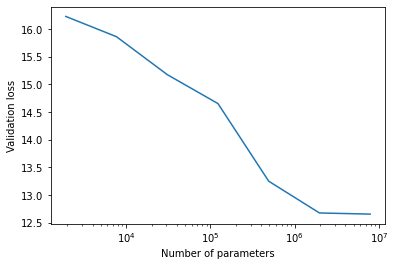

In [29]:
sizes = [128, 512, 2048, 8192, 32768, 131072, 524288]
params = []
results = []

print("Layer size\tParams\tResult")
for layerSize in sizes:
    result = 30
    epochs = 10
    while result > 20:
        model = keras.Sequential()
        model.add(keras.Input(shape=(trainData.shape[1],)))
        model.add(layers.Dense(layerSize, activation="relu"))
        model.add(layers.Dense(1, activation="relu"))
        history = test_model(model, epochs, verbose=0)
        result = np.mean(history.history['val_loss'][-3:])
    results.append(result)
    trainable_count = count_params(model.trainable_weights)
    params.append(trainable_count)
    print(str(layerSize)+"\t\t"+str(params[-1])+"\t"+str(results[-1]))

plt.plot(params, results)
plt.xlabel("Number of parameters")
plt.xscale("log")
plt.ylabel("Validation loss")
plt.show()

Model z jedną warstwą ukrytą poprawia swoją dokładność wraz ze wzrostem liczby parametrów. Brak widocznej poprawy pomiędzy największym i drugim najwększym modelem może wskazywać na uzyskanie wyniku bliskiego granicy możliwości powyższej architektury, jednak by to potwierdzić należałoby rozszerzyć powyższy eksperyment.

## Dwie warstwy ukryte

W kolejnym kroku tworzymy analizę architektur modeli z dwoma warstwami ukrytymi w postaci pełnego przeszukania kombinacji rozmiarów warstw z wybranego zakresu o rozmiarach będących potęgą 2.

In [30]:
sizes = [128, 256, 512, 1024, 2048]
params = []
results = []

print("Layer 1 size\tLayer 2 size\tParams\t\tResult")
for layerSize1 in sizes:
    layerParams = []
    layerResults = []
    for layerSize2 in sizes:
        result = 30
        epochs = 10
        while result > 20:
            model = keras.Sequential()
            model.add(keras.Input(shape=(trainData.shape[1],)))
            model.add(layers.Dense(layerSize1, activation="relu"))
            model.add(layers.Dense(layerSize2, activation="relu"))
            model.add(layers.Dense(1, activation="relu"))
            history = test_model(model, epochs, verbose=0)
            result = np.mean(history.history['val_loss'][-3:])
        layerResults.append(result)
        trainable_count = count_params(model.trainable_weights)
        layerParams.append(trainable_count)
        print(str(layerSize1)+"\t\t"+str(layerSize2)+"\t\t"+str(layerParams[-1])+"\t\t"+str(layerResults[-1]))
    params.append(layerParams)
    results.append(layerResults)

Layer 1 size	Layer 2 size	Params		Result
128		128		18433		15.471370379130045
128		256		35073		15.077158292134603
128		512		68353		14.789669672648111
128		1024		134913		14.119227409362793
128		2048		268033		12.503009478251139
256		128		36609		14.99842103322347
256		256		69633		13.960763613382975
256		512		135681		13.54613971710205
256		1024		267777		13.007824579874674
256		2048		531969		12.746737162272135
512		128		72961		13.5768404006958
512		256		138753		13.368748346964518
512		512		270337		12.978005091349283
512		1024		533505		12.773096720377604
512		2048		1059841		12.054647445678711
1024		128		145665		13.326498667399088
1024		256		276993		13.2479829788208
1024		512		539649		12.264057159423828
1024		1024		1064961		11.988823572794596
1024		2048		2115585		11.84748395284017
2048		128		291073		12.401892026265463
2048		256		553473		12.162149747212728
2048		512		1078273		11.984061241149902
2048		1024		2127873		12.092830022176107
2048		2048		4227073		12.02822240193685


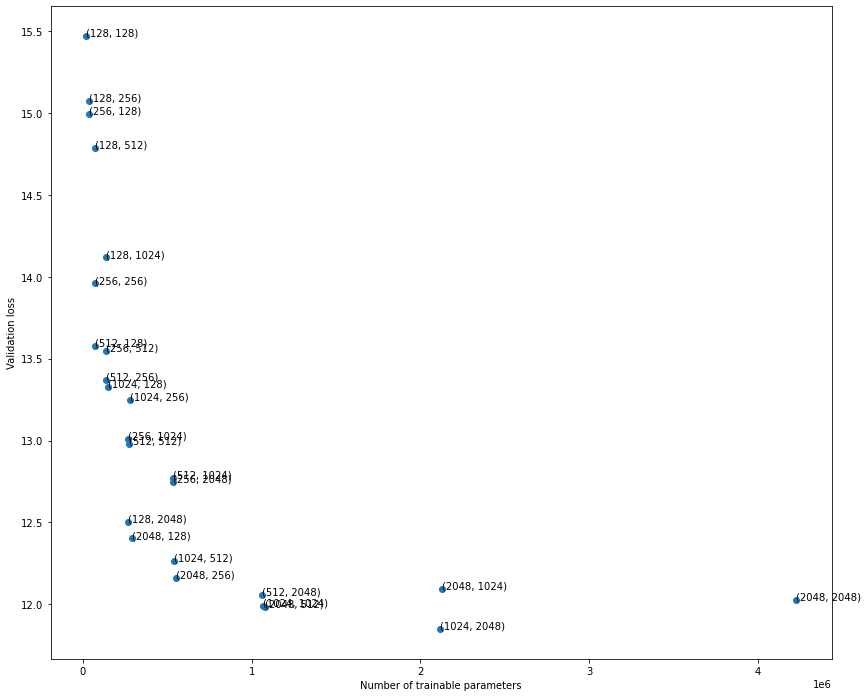

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 12)
ax.scatter(params, results)

for i in range(len(sizes)):
    for j in range(len(sizes)):
        ax.annotate("("+str(sizes[i])+", "+str(sizes[j])+")", (params[i][j], results[i][j]))

plt.xlabel("Number of trainable parameters")
plt.ylabel("Validation loss")
plt.show()

Z dwiema warstwami ukrytymi w sieci i podobną liczbą parametrów co w największych modelach z poprzedniego eksperymentu udało się zejść do wartości błędu RMSE poniżej 12.

Analiza pozwala na wysnucie wniosku, że przy podobnej liczbie parametrów architektura z dwiema warstwami osiąga zdecydowanie lepszy wynik od architektury z jedną warstwą. Wśród przetestowanych modeli wyróżniają się modele o rozmiarach warstw 1024, 1024 i 1024, 2048, jako modele ze stratą ponizej 12 i mniejszą liczbą parametrów.

W kolejnym kroku rozszerzamy najlepsze modele o kolejne warstwy, by sprawdzić czy możemy jeszcze zwiększyć ich dokładność. Wprowadzamy regularyzację poprzez warstwy Dropout i trenujemy dłużej - przez 20 epok.

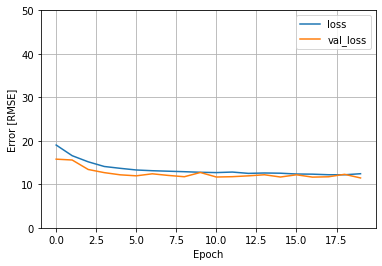

Validation loss: 11.830426851908365


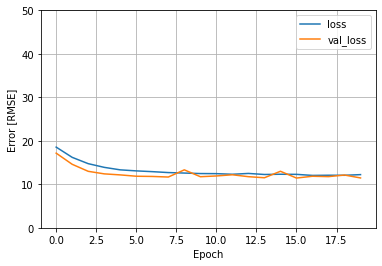

Validation loss: 11.788335800170898


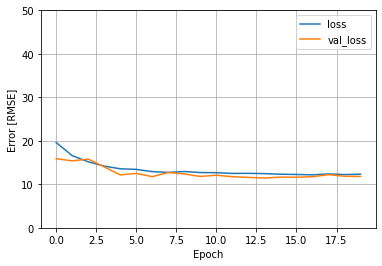

Validation loss: 11.961400667826334


11.961400667826334

In [32]:
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))
      
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))
      
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))

Nieco lepszy od pozostałych jest drugi model. Nieznacznie poprawia on najlepszą uzyskaną dotychczas dokładność. Wykorzystujemy go do oceny kilku funkcji aktywacji innych od ReLU.

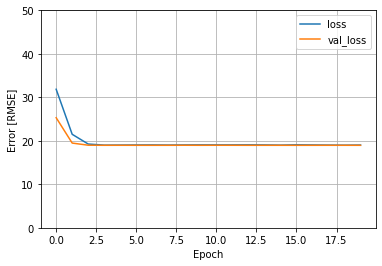

Validation loss: 18.97125816345215


18.97125816345215

In [39]:
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="sigmoid"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048, activation="sigmoid"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="sigmoid"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))

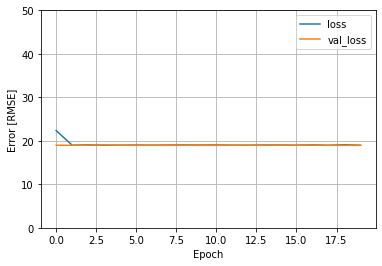

Validation loss: 18.96885617574056


18.96885617574056

In [40]:
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="tanh"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048, activation="tanh"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="tanh"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="tanh"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))

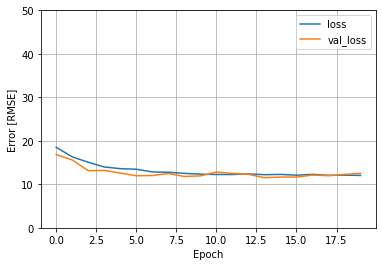

Validation loss: 12.258037885030111


12.258037885030111

In [41]:
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))

O ile model z funkcjami sigmoid i tanh uzyskał bardzo zły wynik, model z funkcją leaky ReLU uzyskał wynik zbliżony do najlepszego. Nadal był on jednak gorszy od uzyskanego z funkcją ReLU, dalej korzystamy zatem z tej funkcji.

## Weryfikacja korzyści z uwzględnienia ceny produktu

W kolejnym kroku sprawdzamy wpływ dodania ceny produktu do modelu. Mimo że nie wybraliśmy tego atrybutu na etapie analizy danych, regresja liniowa wskazała na możliwość uzyskania niewielkiej poprawy dokładności modelu po uwzględnieniu tego atrybutu.

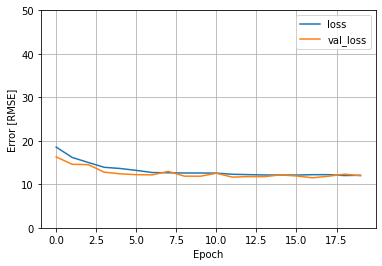

Validation loss: 12.05837631225586


12.05837631225586

In [42]:
data = np.array([]).reshape(deliveryTimes.size, 0)
data = np.concatenate((data, cityCoordAttribute), axis=1)
data = np.concatenate((data, companyAttribute), axis=1)
data = np.concatenate((data, dayAttribute), axis=1)
data = np.concatenate((data, purchaseTimeAttribute), axis=1)
data = np.concatenate((data, priceAttributeLog), axis=1)
data = np.concatenate((data, deliveryTimes), axis = 1)
trainData, trainLabels, testData, testLabels = createDatasets(data, seed=0)

model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2048, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="relu"))
plot_loss(test_model(model, epochs=20, verbose=0))

Jak widać wykorzystanie ceny w modelu nie poprawia uzyskanego wyniku. Potwierdza to wnioski wysnute na etapie analizy danych. Wracamy zatem do pierwotnie wybranych atrybutów.

In [43]:
data = np.array([]).reshape(deliveryTimes.size, 0)
data = np.concatenate((data, cityCoordAttribute), axis=1)
data = np.concatenate((data, companyAttribute), axis=1)
data = np.concatenate((data, dayAttribute), axis=1)
data = np.concatenate((data, purchaseTimeAttribute), axis=1)
data = np.concatenate((data, deliveryTimes), axis = 1)
trainData, trainLabels, testData, testLabels = createDatasets(data, seed=0)

## Wybór modelu docelowego

W ostatnim kroku sprawdzamy dokładność modeli powstałych przez dalsze pogłębienie lub poszerzenie najlepszego modelu. Porównujemy je z dotychczas najlepszym modelem, i wśród nich wybieramy najlepszy jako model docelowy.

Trainable params: 4474369


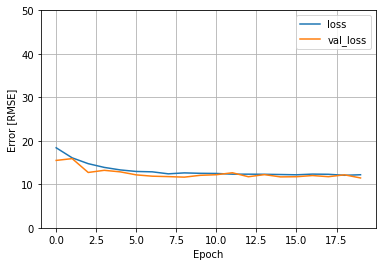

Validation loss: 11.797821998596191
Trainable params: 4490625


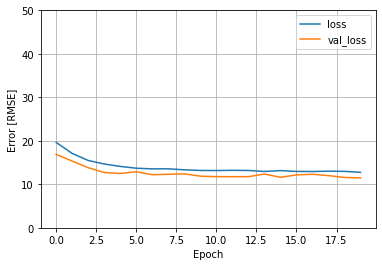

Validation loss: 11.685047467549643
Trainable params: 7424769


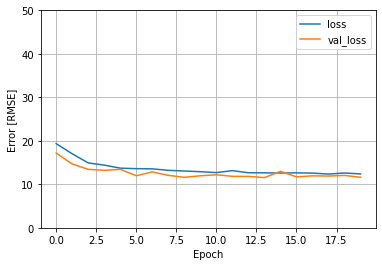

Validation loss: 11.851940790812174
Trainable params: 10650881


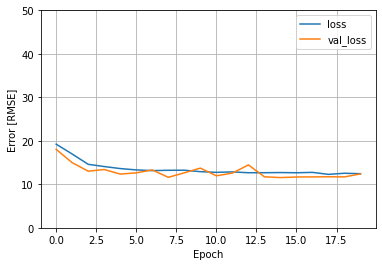

Validation loss: 11.945228894551596


11.945228894551596

In [45]:
model0 = keras.Sequential()
model0.add(keras.Input(shape=(trainData.shape[1],)))
model0.add(layers.Dense(1024, activation="relu"))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(2048, activation="relu"))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(1024, activation="relu"))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(256, activation="relu"))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(1, activation="relu"))
print("Trainable params: "+str(count_params(model0.trainable_weights)))
plot_loss(test_model(model0, epochs=20, verbose=0))

model1 = keras.Sequential()
model1.add(keras.Input(shape=(trainData.shape[1],)))
model1.add(layers.Dense(1024, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(2048, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(1024, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(256, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(64, activation="relu"))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(1, activation="relu"))
print("Trainable params: "+str(count_params(model1.trainable_weights)))
plot_loss(test_model(model1, epochs=20, verbose=0))

model2 = keras.Sequential()
model2.add(keras.Input(shape=(trainData.shape[1],)))
model2.add(layers.Dense(1024, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(2048, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(2048, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(512, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(128, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation="relu"))
print("Trainable params: "+str(count_params(model2.trainable_weights)))
plot_loss(test_model(model2, epochs=20, verbose=0))

model3 = keras.Sequential()
model3.add(keras.Input(shape=(trainData.shape[1],)))
model3.add(layers.Dense(2048, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(2048, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(2048, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1024, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(128, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation="relu"))
print("Trainable params: "+str(count_params(model3.trainable_weights)))
plot_loss(test_model(model3, epochs=20, verbose=0))

Z powyższych modeli najlepszy jest model 1, który uzyskał najmniejszą stratę mimo znacznie mniejszego rozmiaru od modelu 2 i 3. Wybieramy zatem model 1 i zapisujemy go do pliku.

In [46]:
model1.save('full_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: full_model/assets


# Test stworzonych modeli

Po zbudowaniu modeli bazowego i docelowego sprawdzamy ich dokładność na zbiorze testowym.

## Model liniowy

In [47]:
print((testLinearRegression(testData, testLabels, 'base_model.pkl')))

16.93890837536175


## Model docelowy

In [48]:
print(tf.get_static_value(root_mean_squared_error(predict_from_file('full_model', testData, True), testLabels)))

11.646662063131638


Ostateczny wynik modelu docelowego to RMSE poniżej 12. Nie udało się zredukować błędu do okolicy założonych na etapie analizy danych 4.4 godzin - dane najprawdopodobniej nie pozwalają na przewidywanie czasu dostawy z taką dokładnością. Zastosowanie modelu docelowego i tak pozwala na osiągnięcie dokładności predykcji dużo lepszej od błędu względem podawania średniego czasu dostawy oraz prostego modelu liniowego.